In [93]:
import pandas as pd
import numpy as np
from faker import Faker
import os
from datetime import datetime, date
import matplotlib.pyplot as plt

os.makedirs('out', exist_ok=True)
fake = Faker()

In [94]:
# Generate users
num_users = 1000
users = pd.DataFrame({
    'id': range(1, num_users+1),
    'name': [fake.name() for _ in range(num_users)],
    'birth_date': [fake.date_of_birth(minimum_age=18, maximum_age=90) for _ in range(num_users)]
})
users.to_csv('out/users.csv', index=False)
users

,id,name,birth_date
0,1,Rachel Leonard,1959-01-07
1,2,Robert Richardson,1977-01-21
2,3,William Rubio,1971-05-03
3,4,Brandy Chambers,1944-08-10
4,5,William Zhang,1935-03-11
...,...,...,...
995,996,Eric Mcdonald,1958-03-23
996,997,Kevin Oneill,1949-09-25
997,998,Miss Kelly Robbins,1977-10-18
998,999,Gary Lopez PhD,1992-10-28


In [95]:
# Generate visits based on users
from datetime import date

num_visits = 5000
visit_data = []

start_range = date(2024, 5, 1)
end_range = date(2025, 5, 1)

for _ in range(num_visits):
    user = users.sample(1).iloc[0]
    # visit date after user's birth, but within 2024–2025
    visit_date = fake.date_between(
        start_date=max(user['birth_date'], start_range),
        end_date=end_range
    )
    visit_data.append({'id': len(visit_data)+1, 'user_id': user['id'], 'date': visit_date})

visits = pd.DataFrame(visit_data)
visits.to_csv('out/visits.csv', index=False)
visits

,id,user_id,date
0,1,421,2024-06-09
1,2,277,2025-04-14
2,3,114,2025-03-27
3,4,468,2024-08-20
4,5,729,2024-12-12
...,...,...,...
4995,4996,959,2024-07-03
4996,4997,367,2024-08-30
4997,4998,941,2024-06-05
4998,4999,281,2024-08-25


In [96]:
# Index visits by visit date and age group
visits = pd.read_csv('out/visits.csv', parse_dates=['date'])
users = pd.read_csv('out/users.csv', parse_dates=['birth_date'])

df = visits.merge(users, left_on='user_id', right_on='id')

# Age at time of visit
df['age'] = df.apply(
    lambda row: row['date'].year - row['birth_date'].year - ((row['date'].month, row['date'].day) < (row['birth_date'].month, row['birth_date'].day)),
    axis=1
)

# 5 age groups
def age_group(age):
    if age < 30: return '18-29'
    elif age < 45: return '30-44'
    elif age < 60: return '45-59'
    elif age < 75: return '60-74'
    else: return '75+'

df['age_group'] = df['age'].apply(age_group)

# Group by visit date (daily) and age group
indexed = df.groupby([df['date'].dt.to_period('D'), 'age_group']).size().reset_index(name='visits')
indexed.rename(columns={'date': 'visit_date'}, inplace=True)

# Add column for "MMMM YYYY"
indexed['visit_month_label'] = indexed['visit_date'].dt.strftime('%B %Y')

indexed['id'] = range(1, len(indexed)+1)
indexed = indexed[['id','visit_date','visit_month_label','age_group','visits']]
indexed.to_csv('out/indexed.csv', index=False)
indexed


,id,visit_date,visit_month_label,age_group,visits
0,1,2024-05-01,May 2024,18-29,5
1,2,2024-05-01,May 2024,30-44,3
2,3,2024-05-01,May 2024,45-59,2
3,4,2024-05-01,May 2024,60-74,1
4,5,2024-05-01,May 2024,75+,5
...,...,...,...,...,...
1724,1725,2025-04-30,April 2025,18-29,3
1725,1726,2025-04-30,April 2025,30-44,4
1726,1727,2025-04-30,April 2025,45-59,2
1727,1728,2025-04-30,April 2025,60-74,8


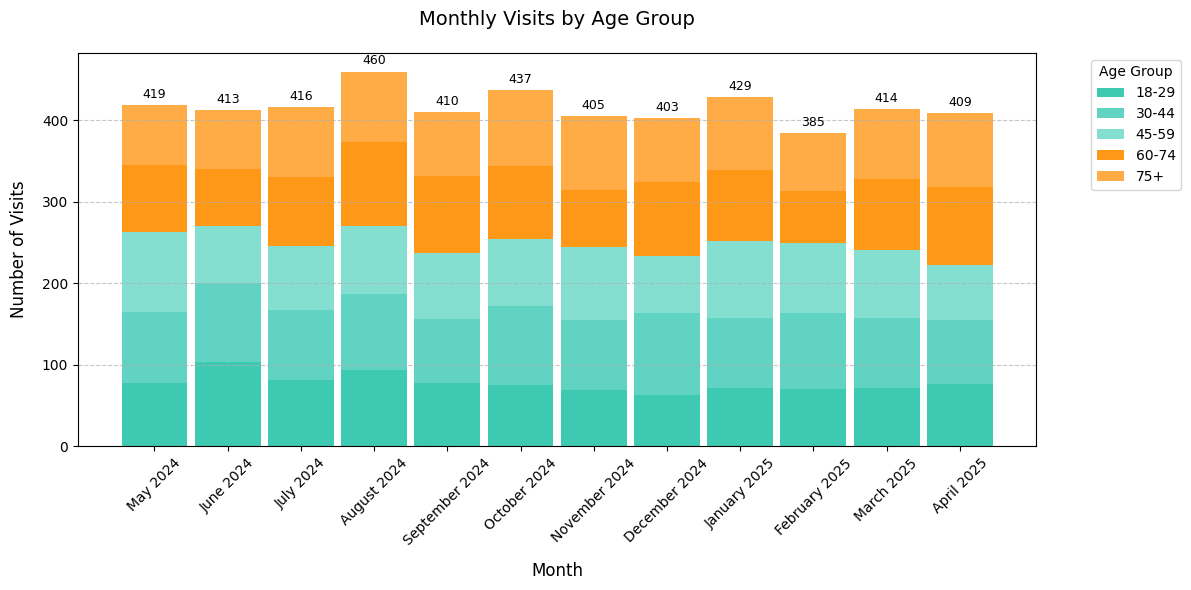

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load indexed data
indexed = pd.read_csv('out/indexed.csv', parse_dates=['visit_date'])

# Create a datetime month column for sorting and a label for display
indexed['visit_month'] = indexed['visit_date'].dt.to_period('M').dt.to_timestamp()
indexed['visit_month_label'] = indexed['visit_date'].dt.strftime('%B %Y')

# Pivot to get age groups as columns, months as index
monthly_age_visits = indexed.pivot_table(
    index='visit_month',  # datetime index for proper sorting
    columns='age_group',
    values='visits',
    aggfunc='sum',
    fill_value=0
)

# Sort by datetime
monthly_age_visits = monthly_age_visits.sort_index()

# Age group order
age_order = ['18-29', '30-44', '45-59', '60-74', '75+']
monthly_age_visits = monthly_age_visits[age_order]

# Colors
colors = ['#3EC9B2', '#61D3C2', '#84DFD1', '#FF9816', '#FFAC47']

# Labels for x-axis
month_labels = monthly_age_visits.index.strftime('%B %Y')

# Plot
plt.figure(figsize=(12, 6))
bottom = np.zeros(len(monthly_age_visits))

for i, age_group in enumerate(monthly_age_visits.columns):
    plt.bar(
        month_labels,
        monthly_age_visits[age_group],
        bottom=bottom,
        label=age_group,
        color=colors[i % len(colors)],
        width=0.9
    )
    bottom += monthly_age_visits[age_group].values

plt.title('Monthly Visits by Age Group', fontsize=14, pad=20)
plt.xlabel('Month', fontsize=12, labelpad=10)
plt.ylabel('Number of Visits', fontsize=12, labelpad=10)
plt.xticks(rotation=45)
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
total_visits = monthly_age_visits.sum(axis=1)
for i, month in enumerate(month_labels):
    plt.text(i, total_visits.iloc[i] + 5, str(total_visits.iloc[i]),
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()
